# Trabajo Práctico Integrador

Tipo de problema: Clasificación

Dataset: "Bone Fracture Multi-Region X-ray Data"

Alumnos:
- Avalos Ribas, Gonzalo
- Silva, Víctor David

Presentación:

https://docs.google.com/presentation/d/11gHDEWSfW7tbPM5viypuyCZf3UhyNn99/pub?start=false&loop=false&delayms=3000



In [ ]:
#Make directory name kaggle
! mkdir ~/.kaggle

In [ ]:

#Copy the json kaggle to this directory
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#Downloading competition dataset
! kaggle datasets download bmadushanirodrigo/fracture-multi-region-x-ray-data

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)
 98% 473M/481M [00:09<00:00, 51.6MB/s]
100% 481M/481M [00:09<00:00, 53.2MB/s]


In [ ]:
from pathlib import Path
from zipfile import ZipFile
import torch
import torchvision
import torchsummary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

from torch.utils.data import Dataset
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
  # specifying the name of the zip file
file = "fracture-multi-region-x-ray-data.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # extract all files
    print('extraction...')
    zip.extractall();
    print('Done!')

extraction...
Done!


In [ ]:
data_dir = Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

## Análisis datos

### Análisis exploratorio de los datos

Se comienza mostrando una imagen y sus dimensiones.

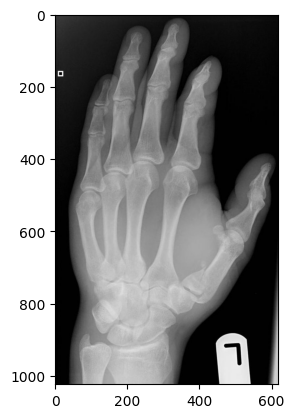

Tamaño imagen: (1024, 617, 3)
La imagen tiene 3 canales.


In [ ]:
# Ruta de la imagen a observar
imagen_fractured = '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/0.jpg'

# Se abre la imagen
ruta_imagen = imagen_fractured
imagen = cv2.imread(ruta_imagen)

# Se muestra la imagen
plt.imshow(imagen)
plt.show()

# Dimensión de la imagen
print(f'Tamaño imagen: {imagen.shape}')

# Número de canales de la imagen
canales = imagen.shape[2]
print(f'La imagen tiene {canales} canales.')

Se quieren observar los 3 canales.

Text(0.5, 1.0, 'Canal azul')

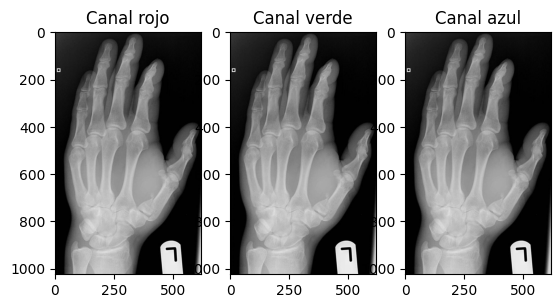

In [ ]:
# Ahora quiero verla como imagen en color
img_color = cv2.imread(imagen_fractured)

# Se pasa la imagen de BGR a RGB
imgRGB = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

# Quiero desensamblar los canales para trabajarlos por separado
im_r, im_g, im_b = cv2.split(imgRGB)

# Nueva figura
fig = plt.figure()

#
ax1=plt.subplot(131)
ax1.imshow(im_r, cmap='gray')
ax1.set_title('Canal rojo')

#
ax2=plt.subplot(132)
ax2.imshow(im_g, cmap='gray')
ax2.set_title('Canal verde')

#
ax3=plt.subplot(133)
ax3.imshow(im_b, cmap='gray')
ax3.set_title('Canal azul')



Se ven iguales, para asegurarse de que lo sean se elige arbitrariamente un valor de columna y se mide la intensidad para todas las filas en los 3 canales.

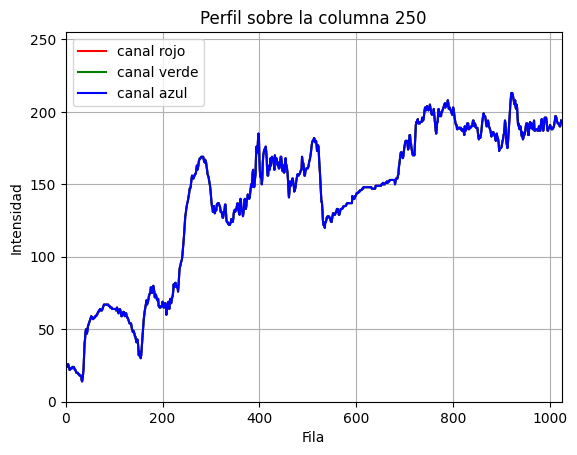

In [ ]:
# Perfil de intensidad sobre la columna 250
idx_col = 250
perfil_color = imgRGB[:,idx_col]
plt.plot(perfil_color[:,0], color='r', label='canal rojo')
plt.plot(perfil_color[:,1], color='g', label='canal verde')
plt.plot(perfil_color[:,2], color='b', label='canal azul')
plt.xlabel('Fila')
plt.ylabel('Intensidad')
plt.title(f'Perfil sobre la columna {idx_col}')
plt.grid()
plt.xlim(0, imagen.shape[0])
plt.ylim(0, 255)
plt.legend()
plt.show()

Se observa que los 3 canales están superpuestos en todas las filas de esa columna, por lo que se puede asegurar de que los 3 canales son iguales. Esto se hace para mantener la compatibilidad con sistemas que esperan imágenes en formato RGB.

## Se crean los dataloaders

In [ ]:
# Tamaño de batch y de las imágenes
BATCH_SIZE = 512
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [ ]:
class BoneFractureImageLoader(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []

        classes = sorted(entry.name for entry in os.scandir(self.root) if entry.is_dir())

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(self.root, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.samples[idx][-1]
        file_path = self.samples[idx][0]
        image = Image.open(file_path)
        image = image.convert('RGB')
        image = np.array(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label).float()
        return image, label

In [ ]:
# Se crean los transforms del dataset, entre ellos se hace un resize
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(size=(IMG_HEIGHT, IMG_WIDTH)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
])
data_test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(size=(IMG_HEIGHT, IMG_WIDTH)),
    torchvision.transforms.ToTensor(),
])

In [ ]:
# Se crean los set de train, valid y test
bone_fracture_train_set = BoneFractureImageLoader(root='/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train',transform= data_transforms)
bone_fracture_val_set = BoneFractureImageLoader(root='/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val',transform= data_transforms)
bone_fracture_test_set = BoneFractureImageLoader(root='/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test',transform= data_test_transforms)
print(f"Se tienen {len(bone_fracture_train_set)} imágenes de train.")
print(f"Se tienen {len(bone_fracture_val_set)} imágenes de val.")
print(f"Se tienen {len(bone_fracture_test_set)} imágenes de test.")


Se tienen 9246 imágenes de train.
Se tienen 829 imágenes de val.
Se tienen 506 imágenes de test.


In [ ]:
# Se crean los dataloders de train, valid y test
bone_fracture_train_loader = torch.utils.data.DataLoader(bone_fracture_train_set, batch_size=BATCH_SIZE, shuffle=True)
bone_fracture_val_loader = torch.utils.data.DataLoader(bone_fracture_val_set, batch_size=BATCH_SIZE, shuffle=True)
bone_fracture_test_loader = torch.utils.data.DataLoader(bone_fracture_test_set, batch_size=BATCH_SIZE, shuffle=True)

### Visualizacion de imagenes transformadas

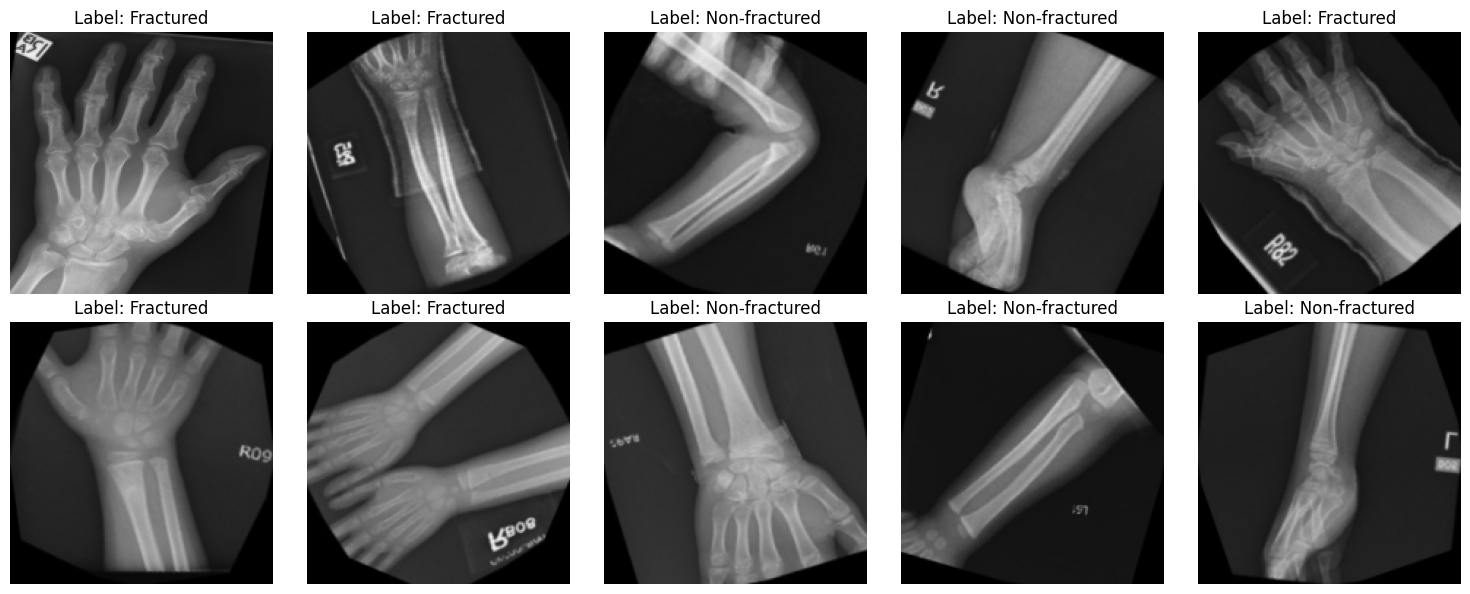

In [ ]:
# Initialize a counter
image_count = 0

# Initialize a list to store images and their corresponding labels
images_list = []
labels_list = []
classes = ['Fractured', 'Non-fractured']
# Set the grid size
grid_size = (2, 5)  # 2 rows and 5 columns

# Initialize a counter
image_count = 0

# Iterate through the DataLoader
for batch in bone_fracture_train_loader:
    # Extract images and labels from the batch
    images, labels = batch

    # Add images and labels to the lists
    for i in range(len(images)):
        images_list.append(images[i])
        labels_list.append(classes[int(labels[i].item())])
        image_count += 1

        # Break after collecting 10 images
        if image_count >= 10:
            break

    # Break the outer loop if 10 images have been collected
    if image_count >= 10:
        break

# Create a figure for the grid
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each image in the grid
for i in range(10):
    axes[i].imshow(images_list[i].permute(1, 2, 0))  # Adjust dimensions for displaying
    axes[i].set_title(f'Label: {labels_list[i]}')
    axes[i].axis('off')  # Hide axes

# Adjust the layout
plt.tight_layout()
plt.show()

### Balance de clases

A continuación, se analiza el balance de clases de train.

In [ ]:
import seaborn as sns

def plot_dataset_balance(dataset, title):
    # Obtener las etiquetas
    labels = [dataset[i][1] for i in range(len(dataset))]

    # Contar las ocurrencias de cada etiqueta
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Convertir las etiquetas a cadenas
    classes = ['Fractured', 'Non-Fractured']

    # Convertir las etiquetas a cadenas
    unique_labels = [classes[i] for i in unique_labels]

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique_labels, y=counts, hue=unique_labels, legend=False)
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.title(title)
    plt.show()

    print(f"Etiquetas: {unique_labels}")
    print(f"Cantidad: {counts}")

In [ ]:
def plot_dataset_balance(dataset, title):
    labels = [dataset[i][1] for i in range(len(dataset))]
    unique_labels, counts = np.unique(labels, return_counts=True)
    unique_labels = unique_labels.astype(int)  # Convertir las etiquetas a enteros
    classes = ['Fractured', 'Non-Fractured']
    unique_labels = [classes[i] for i in unique_labels]

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique_labels, y=counts, palette='Set2')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.title(title)
    plt.show()

<ipython-input-18-67329724363e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette='Set2')


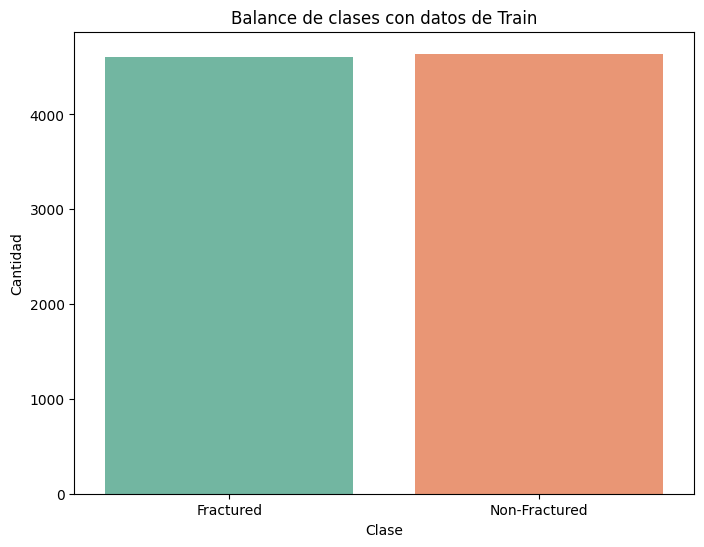

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-18-67329724363e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette='Set2')


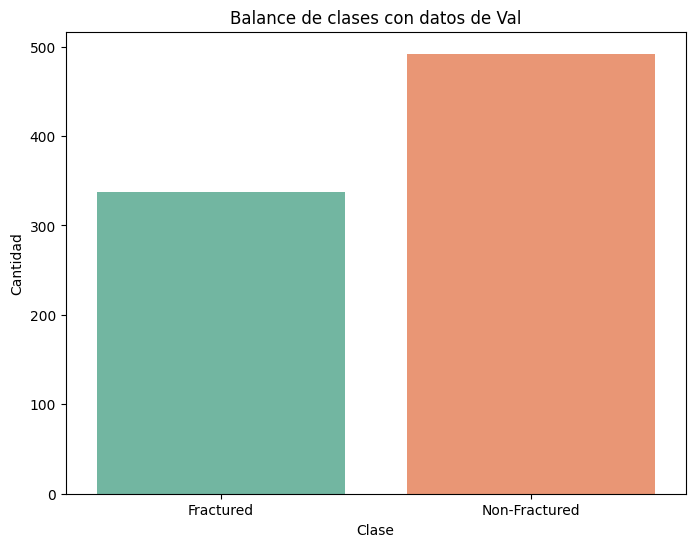

<ipython-input-18-67329724363e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette='Set2')


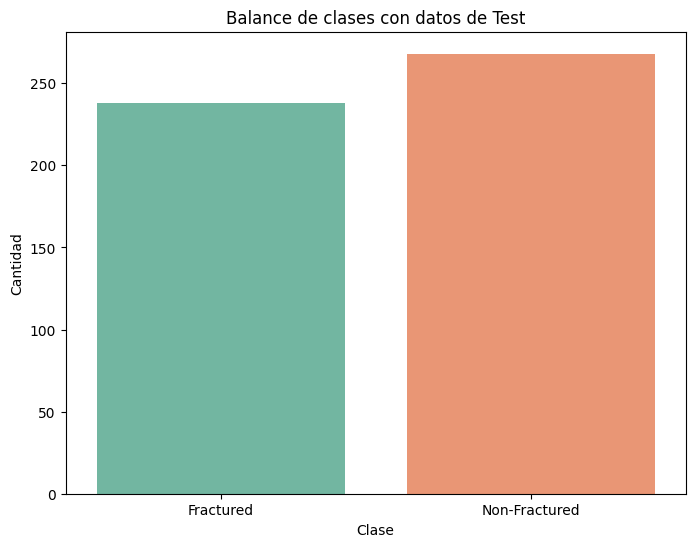

In [ ]:
plot_dataset_balance(bone_fracture_train_set, 'Balance de clases con datos de Train')
plot_dataset_balance(bone_fracture_val_set, 'Balance de clases con datos de Val')
plot_dataset_balance(bone_fracture_test_set, 'Balance de clases con datos de Test')

Se observa que los datos están ligeramente desbalanceados, pero en train es donde están bastate balanceados, por lo que no habría problema en el entrenamiento.

## Se definen los modelos

### Modelo 1: 5 capas convolucionales

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.pool5 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=6400, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = self.pool5(torch.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(1)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, IMG_WIDTH, IMG_HEIGHT))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 180, 180]             448
         MaxPool2d-2           [-1, 16, 90, 90]               0
            Conv2d-3           [-1, 32, 90, 90]           4,640
         MaxPool2d-4           [-1, 32, 45, 45]               0
            Conv2d-5           [-1, 64, 45, 45]          18,496
         MaxPool2d-6           [-1, 64, 22, 22]               0
            Conv2d-7          [-1, 128, 22, 22]          73,856
         MaxPool2d-8          [-1, 128, 11, 11]               0
            Conv2d-9          [-1, 256, 11, 11]         295,168
        MaxPool2d-10            [-1, 256, 5, 5]               0
           Linear-11                  [-1, 512]       3,277,312
           Linear-12                    [-1, 1]             513
Total params: 3,670,433
Trainable params: 3,670,433
Non-trainable params: 0
---------------------------

#### Entrenamiento con validación y gráficas.

In [ ]:
# Se arman las funciones necesarias para realizar el entrenamiento

# Se usa tqdm para graficar la barra de avance
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def fit(model, dataloader_train, dataloader_valid, epochs=10, patience=5):
    model.to(device)
    best_val_loss = float('inf')
    best_model_weights = None
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader_train)
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y_hat = y_hat.squeeze()
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            #acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            acc = ((torch.sigmoid(y_hat) > 0.5) == y).float().mean().item()
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader_valid)
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y_hat = y_hat.squeeze()
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                #acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                acc = ((torch.sigmoid(y_hat) > 0.5) == y).float().mean().item()
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

        # Early stopping based on validation loss
        if epoch_v_loss[-1] < best_val_loss:
            best_val_loss = epoch_v_loss[-1]
            best_model_weights = model.state_dict()  # Save best model weights
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

    if best_model_weights is not None:
      model.load_state_dict(best_model_weights)
      print('Best model weights restored.')

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

    # Se guardan los valores obtenidos de de loss y acc para train y loss
    train_loss = epoch_t_loss[-epochs_no_improve-1]
    val_loss = epoch_v_loss[-epochs_no_improve-1]
    train_acc = epoch_t_acc[-epochs_no_improve-1]
    val_acc = epoch_v_acc[-epochs_no_improve-1]

    # Se muestran los valores obtenidos de de loss y acc para train y loss
    print('train loss: ', train_loss)
    print('val loss: ', val_loss)
    print('train acc: ', train_acc)
    print('val acc: ', val_acc)

    # Se devuelven los valores obtenidos de loss y acc para train y loss
    return train_loss, val_loss, train_acc, val_acc



  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val_loss 0.64745 val_acc 0.67596: 100%|██████████| 2/2 [00:11<00:00,  5.72s/it]


Epoch 1/50 loss 0.69007 val_loss 0.64745 acc 0.53938 val_acc 0.67596


val_loss 0.63728 val_acc 0.67167: 100%|██████████| 2/2 [00:11<00:00,  5.97s/it]


Epoch 2/50 loss 0.63467 val_loss 0.63728 acc 0.64613 val_acc 0.67167


val_loss 0.57994 val_acc 0.73605: 100%|██████████| 2/2 [00:11<00:00,  5.71s/it]


Epoch 3/50 loss 0.58100 val_loss 0.57994 acc 0.70152 val_acc 0.73605


val_loss 0.56894 val_acc 0.72726: 100%|██████████| 2/2 [00:11<00:00,  5.52s/it]


Epoch 4/50 loss 0.55931 val_loss 0.56894 acc 0.72640 val_acc 0.72726


val_loss 0.52932 val_acc 0.79088: 100%|██████████| 2/2 [00:11<00:00,  5.72s/it]


Epoch 5/50 loss 0.51856 val_loss 0.52932 acc 0.76197 val_acc 0.79088


val_loss 0.50604 val_acc 0.79366: 100%|██████████| 2/2 [00:10<00:00,  5.28s/it]


Epoch 6/50 loss 0.44968 val_loss 0.50604 acc 0.82048 val_acc 0.79366


val_loss 0.45378 val_acc 0.85142: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


Epoch 7/50 loss 0.40969 val_loss 0.45378 acc 0.83067 val_acc 0.85142


val_loss 0.48410 val_acc 0.78382: 100%|██████████| 2/2 [00:11<00:00,  5.64s/it]


Epoch 8/50 loss 0.34744 val_loss 0.48410 acc 0.86088 val_acc 0.78382


val_loss 0.43461 val_acc 0.84737: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


Epoch 9/50 loss 0.33937 val_loss 0.43461 acc 0.85492 val_acc 0.84737


val_loss 0.48622 val_acc 0.83617: 100%|██████████| 2/2 [00:11<00:00,  5.70s/it]


Epoch 10/50 loss 0.26077 val_loss 0.48622 acc 0.89782 val_acc 0.83617


val_loss 0.35270 val_acc 0.86712: 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


Epoch 11/50 loss 0.25277 val_loss 0.35270 acc 0.89553 val_acc 0.86712


val_loss 0.43563 val_acc 0.83753: 100%|██████████| 2/2 [00:11<00:00,  5.63s/it]


Epoch 12/50 loss 0.20132 val_loss 0.43563 acc 0.91610 val_acc 0.83753


val_loss 0.32245 val_acc 0.88515: 100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


Epoch 13/50 loss 0.19029 val_loss 0.32245 acc 0.92608 val_acc 0.88515


val_loss 0.34285 val_acc 0.87982: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


Epoch 14/50 loss 0.15121 val_loss 0.34285 acc 0.94438 val_acc 0.87982


val_loss 0.31938 val_acc 0.91114: 100%|██████████| 2/2 [00:11<00:00,  5.67s/it]


Epoch 15/50 loss 0.13371 val_loss 0.31938 acc 0.95116 val_acc 0.91114


val_loss 0.30591 val_acc 0.90874: 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


Epoch 16/50 loss 0.13074 val_loss 0.30591 acc 0.95415 val_acc 0.90874


val_loss 0.35443 val_acc 0.89642: 100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


Epoch 17/50 loss 0.11046 val_loss 0.35443 acc 0.96454 val_acc 0.89642


val_loss 0.33094 val_acc 0.90460: 100%|██████████| 2/2 [00:11<00:00,  5.66s/it]


Epoch 18/50 loss 0.11422 val_loss 0.33094 acc 0.95919 val_acc 0.90460


val_loss 0.28916 val_acc 0.91580: 100%|██████████| 2/2 [00:11<00:00,  5.67s/it]


Epoch 19/50 loss 0.08870 val_loss 0.28916 acc 0.97194 val_acc 0.91580


val_loss 0.31322 val_acc 0.91768: 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


Epoch 20/50 loss 0.07596 val_loss 0.31322 acc 0.97769 val_acc 0.91768


val_loss 0.27020 val_acc 0.92661: 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


Epoch 21/50 loss 0.06329 val_loss 0.27020 acc 0.98324 val_acc 0.92661


val_loss 0.23128 val_acc 0.92834: 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


Epoch 22/50 loss 0.06383 val_loss 0.23128 acc 0.98232 val_acc 0.92834


val_loss 0.34028 val_acc 0.90814: 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


Epoch 23/50 loss 0.05702 val_loss 0.34028 acc 0.98334 val_acc 0.90814


val_loss 0.33454 val_acc 0.90295: 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


Epoch 24/50 loss 0.07217 val_loss 0.33454 acc 0.97625 val_acc 0.90295


val_loss 0.21805 val_acc 0.93578: 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


Epoch 25/50 loss 0.07084 val_loss 0.21805 acc 0.97851 val_acc 0.93578


val_loss 0.25028 val_acc 0.93600: 100%|██████████| 2/2 [00:11<00:00,  5.64s/it]


Epoch 26/50 loss 0.06235 val_loss 0.25028 acc 0.98139 val_acc 0.93600


val_loss 0.25414 val_acc 0.93285: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Epoch 27/50 loss 0.04656 val_loss 0.25414 acc 0.98694 val_acc 0.93285


val_loss 0.17457 val_acc 0.95117: 100%|██████████| 2/2 [00:11<00:00,  5.66s/it]


Epoch 28/50 loss 0.05192 val_loss 0.17457 acc 0.98592 val_acc 0.95117


val_loss 0.20685 val_acc 0.94209: 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


Epoch 29/50 loss 0.03998 val_loss 0.20685 acc 0.98951 val_acc 0.94209


val_loss 0.21102 val_acc 0.94013: 100%|██████████| 2/2 [00:11<00:00,  5.71s/it]


Epoch 30/50 loss 0.03468 val_loss 0.21102 acc 0.98879 val_acc 0.94013


val_loss 0.18398 val_acc 0.94607: 100%|██████████| 2/2 [00:10<00:00,  5.32s/it]


Epoch 31/50 loss 0.03442 val_loss 0.18398 acc 0.99167 val_acc 0.94607


val_loss 0.17181 val_acc 0.94464: 100%|██████████| 2/2 [00:11<00:00,  5.61s/it]


Epoch 32/50 loss 0.02676 val_loss 0.17181 acc 0.99383 val_acc 0.94464


val_loss 0.13724 val_acc 0.96447: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


Epoch 33/50 loss 0.02298 val_loss 0.13724 acc 0.99394 val_acc 0.96447


val_loss 0.15898 val_acc 0.95681: 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


Epoch 34/50 loss 0.02253 val_loss 0.15898 acc 0.99404 val_acc 0.95681


val_loss 0.15913 val_acc 0.95643: 100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


Epoch 35/50 loss 0.02413 val_loss 0.15913 acc 0.99166 val_acc 0.95643


val_loss 0.18993 val_acc 0.95433: 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]


Epoch 36/50 loss 0.05787 val_loss 0.18993 acc 0.98067 val_acc 0.95433


val_loss 0.15252 val_acc 0.95936: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


Epoch 37/50 loss 0.04140 val_loss 0.15252 acc 0.98715 val_acc 0.95936


val_loss 0.13928 val_acc 0.96019: 100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


Epoch 38/50 loss 0.02548 val_loss 0.13928 acc 0.99332 val_acc 0.96019
Early stopping after 39 epochs


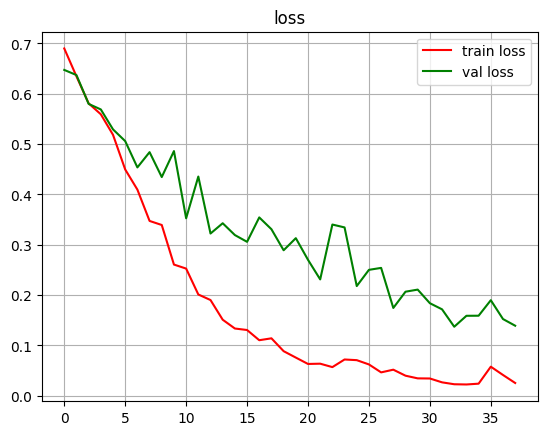

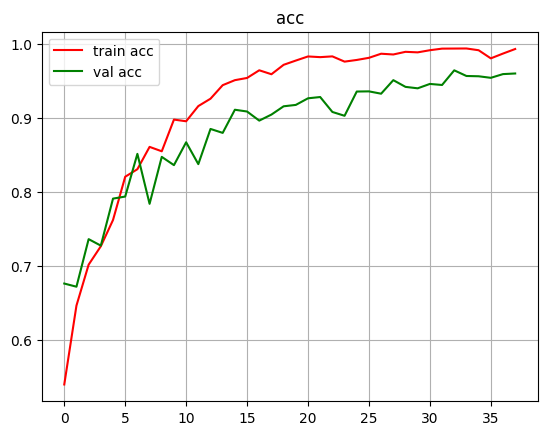

train loss:  0.025484468702128844
val loss:  0.13928163796663284
train acc:  0.9933182565789473
val acc:  0.9601889252662659


In [ ]:
train_loss_1, val_loss_1, train_acc_1, val_acc_1 = fit(conv_model, bone_fracture_train_loader, bone_fracture_val_loader, epochs=50)

## Modelo 2: ResNet18 - Fine Tuning

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
class ResNet18(torch.nn.Module):
  def __init__(self, n_classes=1):
    super(ResNet18, self).__init__()
    self.classes=n_classes
    self.model = models.resnet18(pretrained=True)
    self.model.fc = torch.nn.Linear(self.model.fc.in_features, n_classes)

  def forward(self, x):
    x = self.model(x)
    return x

  def freeze(self):
    for param in self.model.parameters():
      param.requires_grad = False
    self.model.fc = torch.nn.Linear(self.model.fc.in_features, self.classes)

  def unfreeze(self):
    for param in self.model.parameters():
      param.requires_grad = True

# Crear una instancia del modelo
resnet_fine_tuning_model = ResNet18(n_classes=1)
resnet_fine_tuning_model.to('cuda')
torchsummary.summary(resnet_fine_tuning_model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 90, 90]           9,408
       BatchNorm2d-2           [-1, 64, 90, 90]             128
              ReLU-3           [-1, 64, 90, 90]               0
         MaxPool2d-4           [-1, 64, 45, 45]               0
            Conv2d-5           [-1, 64, 45, 45]          36,864
       BatchNorm2d-6           [-1, 64, 45, 45]             128
              ReLU-7           [-1, 64, 45, 45]               0
            Conv2d-8           [-1, 64, 45, 45]          36,864
       BatchNorm2d-9           [-1, 64, 45, 45]             128
             ReLU-10           [-1, 64, 45, 45]               0
       BasicBlock-11           [-1, 64, 45, 45]               0
           Conv2d-12           [-1, 64, 45, 45]          36,864
      BatchNorm2d-13           [-1, 64, 45, 45]             128
             ReLU-14           [-1, 64,

Se entrena el modelo usando la función de train anterior.

val_loss 0.89044 val_acc 0.74694: 100%|██████████| 2/2 [00:11<00:00,  5.84s/it]


Epoch 1/50 loss 0.20009 val_loss 0.89044 acc 0.90944 val_acc 0.74694


val_loss 0.13001 val_acc 0.94937: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]


Epoch 2/50 loss 0.02029 val_loss 0.13001 acc 0.99260 val_acc 0.94937


val_loss 0.08732 val_acc 0.97040: 100%|██████████| 2/2 [00:11<00:00,  5.89s/it]


Epoch 3/50 loss 0.01310 val_loss 0.08732 acc 0.99630 val_acc 0.97040


val_loss 0.05939 val_acc 0.97979: 100%|██████████| 2/2 [00:11<00:00,  5.90s/it]


Epoch 4/50 loss 0.00694 val_loss 0.05939 acc 0.99794 val_acc 0.97979


val_loss 0.08824 val_acc 0.95876: 100%|██████████| 2/2 [00:11<00:00,  5.84s/it]


Epoch 5/50 loss 0.00581 val_loss 0.08824 acc 0.99784 val_acc 0.95876


val_loss 0.02128 val_acc 0.99294: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


Epoch 6/50 loss 0.00347 val_loss 0.02128 acc 0.99897 val_acc 0.99294


val_loss 0.03211 val_acc 0.98881: 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]


Epoch 7/50 loss 0.00373 val_loss 0.03211 acc 0.99907 val_acc 0.98881


val_loss 0.02738 val_acc 0.99332: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


Epoch 8/50 loss 0.00227 val_loss 0.02738 acc 0.99949 val_acc 0.99332


val_loss 0.07596 val_acc 0.98017: 100%|██████████| 2/2 [00:11<00:00,  5.73s/it]


Epoch 9/50 loss 0.00252 val_loss 0.07596 acc 0.99938 val_acc 0.98017


val_loss 0.06143 val_acc 0.98002: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]


Epoch 10/50 loss 0.00235 val_loss 0.06143 acc 0.99949 val_acc 0.98002


val_loss 0.03751 val_acc 0.98137: 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


Epoch 11/50 loss 0.00355 val_loss 0.03751 acc 0.99877 val_acc 0.98137
Early stopping after 12 epochs
Best model weights restored.


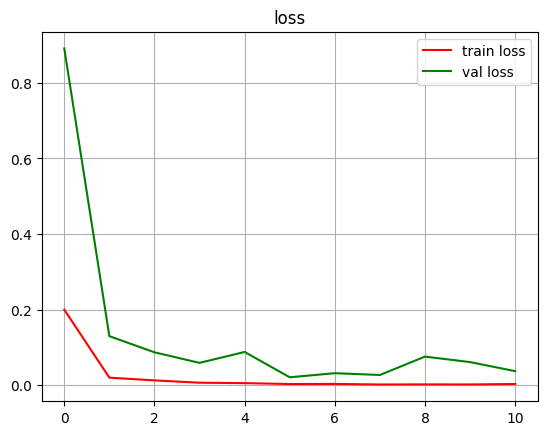

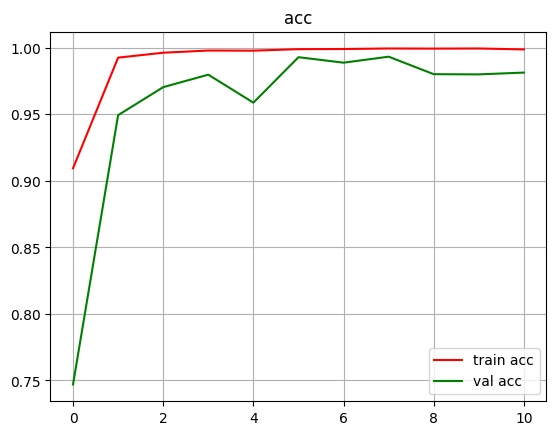

train loss:  0.003471806869033332
val loss:  0.021280745044350624
train acc:  0.9989720394736842
val acc:  0.9929391741752625


In [ ]:
train_loss_ft, val_loss_ft, train_acc_ft, val_acc_ft = fit(resnet_fine_tuning_model, bone_fracture_train_loader, bone_fracture_val_loader, epochs=50)


## Modelo 3: ResNet18 - Feature extractor

In [ ]:
# Crear una instancia del modelo
resnet_feature_extractor_model = ResNet18(n_classes=1)
resnet_feature_extractor_model.freeze()
resnet_feature_extractor_model.to('cuda')
torchsummary.summary(resnet_feature_extractor_model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 90, 90]           9,408
       BatchNorm2d-2           [-1, 64, 90, 90]             128
              ReLU-3           [-1, 64, 90, 90]               0
         MaxPool2d-4           [-1, 64, 45, 45]               0
            Conv2d-5           [-1, 64, 45, 45]          36,864
       BatchNorm2d-6           [-1, 64, 45, 45]             128
              ReLU-7           [-1, 64, 45, 45]               0
            Conv2d-8           [-1, 64, 45, 45]          36,864
       BatchNorm2d-9           [-1, 64, 45, 45]             128
             ReLU-10           [-1, 64, 45, 45]               0
       BasicBlock-11           [-1, 64, 45, 45]               0
           Conv2d-12           [-1, 64, 45, 45]          36,864
      BatchNorm2d-13           [-1, 64, 45, 45]             128
             ReLU-14           [-1, 64,

val_loss 0.62676 val_acc 0.68940: 100%|██████████| 2/2 [00:11<00:00,  5.76s/it]


Epoch 1/50 loss 0.66804 val_loss 0.62676 acc 0.58472 val_acc 0.68940


val_loss 0.61567 val_acc 0.69684: 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]


Epoch 2/50 loss 0.60608 val_loss 0.61567 acc 0.70360 val_acc 0.69684


val_loss 0.58339 val_acc 0.73815: 100%|██████████| 2/2 [00:11<00:00,  5.94s/it]


Epoch 3/50 loss 0.56828 val_loss 0.58339 acc 0.74376 val_acc 0.73815


val_loss 0.54593 val_acc 0.75535: 100%|██████████| 2/2 [00:12<00:00,  6.00s/it]


Epoch 4/50 loss 0.53310 val_loss 0.54593 acc 0.77648 val_acc 0.75535


val_loss 0.49528 val_acc 0.78825: 100%|██████████| 2/2 [00:11<00:00,  5.81s/it]


Epoch 5/50 loss 0.51118 val_loss 0.49528 acc 0.78368 val_acc 0.78825


val_loss 0.48565 val_acc 0.78577: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


Epoch 6/50 loss 0.49092 val_loss 0.48565 acc 0.79652 val_acc 0.78577


val_loss 0.47561 val_acc 0.80883: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


Epoch 7/50 loss 0.46882 val_loss 0.47561 acc 0.81474 val_acc 0.80883


val_loss 0.47342 val_acc 0.82671: 100%|██████████| 2/2 [00:11<00:00,  5.76s/it]


Epoch 8/50 loss 0.45670 val_loss 0.47342 acc 0.81649 val_acc 0.82671


val_loss 0.45131 val_acc 0.82198: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]


Epoch 9/50 loss 0.44831 val_loss 0.45131 acc 0.81359 val_acc 0.82198


val_loss 0.45302 val_acc 0.80778: 100%|██████████| 2/2 [00:11<00:00,  5.91s/it]


Epoch 10/50 loss 0.43728 val_loss 0.45302 acc 0.82099 val_acc 0.80778


val_loss 0.43508 val_acc 0.82844: 100%|██████████| 2/2 [00:11<00:00,  5.90s/it]


Epoch 11/50 loss 0.42742 val_loss 0.43508 acc 0.83334 val_acc 0.82844


val_loss 0.43772 val_acc 0.81387: 100%|██████████| 2/2 [00:11<00:00,  5.80s/it]


Epoch 12/50 loss 0.42385 val_loss 0.43772 acc 0.83065 val_acc 0.81387


val_loss 0.42956 val_acc 0.83190: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


Epoch 13/50 loss 0.41076 val_loss 0.42956 acc 0.83592 val_acc 0.83190


val_loss 0.41847 val_acc 0.83137: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


Epoch 14/50 loss 0.40460 val_loss 0.41847 acc 0.83796 val_acc 0.83137


val_loss 0.41449 val_acc 0.82859: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]


Epoch 15/50 loss 0.39929 val_loss 0.41449 acc 0.83477 val_acc 0.82859


val_loss 0.41371 val_acc 0.82506: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


Epoch 16/50 loss 0.39938 val_loss 0.41371 acc 0.83714 val_acc 0.82506


val_loss 0.40164 val_acc 0.84549: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


Epoch 17/50 loss 0.39721 val_loss 0.40164 acc 0.83888 val_acc 0.84549


val_loss 0.40982 val_acc 0.84361: 100%|██████████| 2/2 [00:11<00:00,  5.98s/it]


Epoch 18/50 loss 0.39491 val_loss 0.40982 acc 0.83640 val_acc 0.84361


val_loss 0.39052 val_acc 0.83107: 100%|██████████| 2/2 [00:11<00:00,  5.98s/it]


Epoch 19/50 loss 0.38321 val_loss 0.39052 acc 0.84711 val_acc 0.83107


val_loss 0.39188 val_acc 0.82701: 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


Epoch 20/50 loss 0.37359 val_loss 0.39188 acc 0.85443 val_acc 0.82701


val_loss 0.38544 val_acc 0.83895: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


Epoch 21/50 loss 0.37514 val_loss 0.38544 acc 0.85142 val_acc 0.83895


val_loss 0.39788 val_acc 0.83640: 100%|██████████| 2/2 [00:11<00:00,  5.80s/it]


Epoch 22/50 loss 0.37146 val_loss 0.39788 acc 0.84989 val_acc 0.83640


val_loss 0.37701 val_acc 0.84158: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


Epoch 23/50 loss 0.37255 val_loss 0.37701 acc 0.84534 val_acc 0.84158


val_loss 0.38354 val_acc 0.83986: 100%|██████████| 2/2 [00:11<00:00,  5.90s/it]


Epoch 24/50 loss 0.36387 val_loss 0.38354 acc 0.85038 val_acc 0.83986


val_loss 0.40753 val_acc 0.82288: 100%|██████████| 2/2 [00:11<00:00,  5.87s/it]


Epoch 25/50 loss 0.36225 val_loss 0.40753 acc 0.85338 val_acc 0.82288


val_loss 0.39218 val_acc 0.83377: 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


Epoch 26/50 loss 0.36056 val_loss 0.39218 acc 0.85450 val_acc 0.83377


val_loss 0.38065 val_acc 0.84421: 100%|██████████| 2/2 [00:11<00:00,  5.91s/it]


Epoch 27/50 loss 0.35112 val_loss 0.38065 acc 0.86368 val_acc 0.84421


val_loss 0.37883 val_acc 0.83685: 100%|██████████| 2/2 [00:11<00:00,  5.86s/it]


Epoch 28/50 loss 0.35786 val_loss 0.37883 acc 0.85191 val_acc 0.83685
Early stopping after 29 epochs
Best model weights restored.


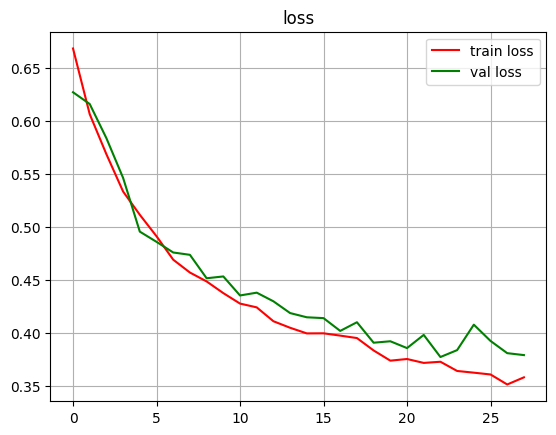

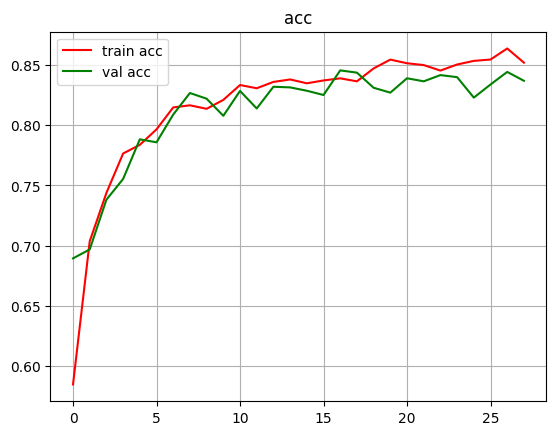

train loss:  0.3725548135606866
val loss:  0.37701094150543213
train acc:  0.8453399131172582
val acc:  0.841584324836731


In [ ]:
train_loss_ft, val_loss_ft, train_acc_ft, val_acc_ft = fit(resnet_feature_extractor_model, bone_fracture_train_loader, bone_fracture_val_loader, epochs=50)

## Modelo 4: MobileNetV3 Small - Fine Tune

In [ ]:
class MobileNetV3(torch.nn.Module):
  def __init__(self, n_classes=1,preTrained=True):
    super(MobileNetV3, self).__init__()
    self.classes=n_classes
    self.model = models.mobilenet_v3_small(pretrained=preTrained)
    # self.model.dropout = torch.nn.Dropout(p=0.95)
    self.model.classifier[3] = torch.nn.Linear(self.model.classifier[3].in_features, self.classes)

  def forward(self, x):
    x = self.model(x)
    return x

  def freeze(self):
    for param in self.model.parameters():
      param.requires_grad = False
    self.model.classifier[3] = torch.nn.Linear(self.model.classifier[3].in_features, self.classes)

  def unfreeze(self):
    for param in self.model.parameters():
      param.requires_grad = True

# Crear una instancia del modelo
mobile_fine_tuning_model = MobileNetV3(n_classes=1)
mobile_fine_tuning_model.to('cuda')
torchsummary.summary(mobile_fine_tuning_model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 90, 90]             432
       BatchNorm2d-2           [-1, 16, 90, 90]              32
         Hardswish-3           [-1, 16, 90, 90]               0
            Conv2d-4           [-1, 16, 45, 45]             144
       BatchNorm2d-5           [-1, 16, 45, 45]              32
              ReLU-6           [-1, 16, 45, 45]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 45, 45]               0
           Conv2d-13           [-1, 16, 45, 45]             256
      BatchNorm2d-14           [-1, 16,

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val_loss 0.62865 val_acc 0.66514: 100%|██████████| 2/2 [00:09<00:00,  5.00s/it]


Epoch 1/50 loss 0.32890 val_loss 0.62865 acc 0.85626 val_acc 0.66514


val_loss 0.69574 val_acc 0.72358: 100%|██████████| 2/2 [00:10<00:00,  5.08s/it]


Epoch 2/50 loss 0.04734 val_loss 0.69574 acc 0.98355 val_acc 0.72358


val_loss 0.62999 val_acc 0.72779: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


Epoch 3/50 loss 0.01349 val_loss 0.62999 acc 0.99527 val_acc 0.72779


val_loss 0.57925 val_acc 0.71336: 100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Epoch 4/50 loss 0.02237 val_loss 0.57925 acc 0.99320 val_acc 0.71336


val_loss 0.50603 val_acc 0.75332: 100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


Epoch 5/50 loss 0.02768 val_loss 0.50603 acc 0.99012 val_acc 0.75332


val_loss 0.48408 val_acc 0.77466: 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Epoch 6/50 loss 0.01507 val_loss 0.48408 acc 0.99507 val_acc 0.77466


val_loss 0.75352 val_acc 0.68189: 100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


Epoch 7/50 loss 0.01219 val_loss 0.75352 acc 0.99474 val_acc 0.68189


val_loss 0.46353 val_acc 0.78585: 100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch 8/50 loss 0.02019 val_loss 0.46353 acc 0.99198 val_acc 0.78585


val_loss 0.43254 val_acc 0.83062: 100%|██████████| 2/2 [00:11<00:00,  5.53s/it]


Epoch 9/50 loss 0.00621 val_loss 0.43254 acc 0.99887 val_acc 0.83062


val_loss 0.50427 val_acc 0.77841: 100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


Epoch 10/50 loss 0.00617 val_loss 0.50427 acc 0.99784 val_acc 0.77841


val_loss 0.45134 val_acc 0.80876: 100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Epoch 11/50 loss 0.00207 val_loss 0.45134 acc 0.99959 val_acc 0.80876


val_loss 0.49097 val_acc 0.79569: 100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Epoch 12/50 loss 0.00210 val_loss 0.49097 acc 0.99949 val_acc 0.79569


val_loss 0.35330 val_acc 0.85127: 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


Epoch 13/50 loss 0.00180 val_loss 0.35330 acc 0.99938 val_acc 0.85127


val_loss 0.38054 val_acc 0.86066: 100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Epoch 14/50 loss 0.00110 val_loss 0.38054 acc 0.99979 val_acc 0.86066


val_loss 0.42622 val_acc 0.84872: 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]


Epoch 15/50 loss 0.00122 val_loss 0.42622 acc 0.99959 val_acc 0.84872


val_loss 0.45411 val_acc 0.84053: 100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


Epoch 16/50 loss 0.00078 val_loss 0.45411 acc 0.99990 val_acc 0.84053


val_loss 0.39887 val_acc 0.86990: 100%|██████████| 2/2 [00:10<00:00,  5.27s/it]


Epoch 17/50 loss 0.00037 val_loss 0.39887 acc 0.99990 val_acc 0.86990


val_loss 0.39423 val_acc 0.86945: 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Epoch 18/50 loss 0.00045 val_loss 0.39423 acc 0.99979 val_acc 0.86945


val_loss 0.30295 val_acc 0.89431: 100%|██████████| 2/2 [00:10<00:00,  5.00s/it]


Epoch 19/50 loss 0.00132 val_loss 0.30295 acc 1.00000 val_acc 0.89431


val_loss 0.30158 val_acc 0.87606: 100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


Epoch 20/50 loss 0.00471 val_loss 0.30158 acc 0.99856 val_acc 0.87606


val_loss 0.28261 val_acc 0.88853: 100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


Epoch 21/50 loss 0.00248 val_loss 0.28261 acc 0.99918 val_acc 0.88853


val_loss 0.21884 val_acc 0.90310: 100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


Epoch 22/50 loss 0.00775 val_loss 0.21884 acc 0.99804 val_acc 0.90310


val_loss 0.88308 val_acc 0.71749: 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Epoch 23/50 loss 0.01314 val_loss 0.88308 acc 0.99558 val_acc 0.71749


val_loss 1.74400 val_acc 0.60107: 100%|██████████| 2/2 [00:08<00:00,  4.50s/it]


Epoch 24/50 loss 0.00632 val_loss 1.74400 acc 0.99722 val_acc 0.60107


val_loss 0.76056 val_acc 0.72290: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


Epoch 25/50 loss 0.01921 val_loss 0.76056 acc 0.99383 val_acc 0.72290


val_loss 0.41980 val_acc 0.83280: 100%|██████████| 2/2 [00:09<00:00,  4.96s/it]


Epoch 26/50 loss 0.00386 val_loss 0.41980 acc 0.99866 val_acc 0.83280


val_loss 0.26161 val_acc 0.90092: 100%|██████████| 2/2 [00:09<00:00,  4.97s/it]


Epoch 27/50 loss 0.00269 val_loss 0.26161 acc 0.99783 val_acc 0.90092


val_loss 0.33303 val_acc 0.87516: 100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Epoch 28/50 loss 0.00829 val_loss 0.33303 acc 0.99670 val_acc 0.87516


val_loss 0.29671 val_acc 0.91129: 100%|██████████| 2/2 [00:10<00:00,  5.16s/it]


Epoch 29/50 loss 0.01015 val_loss 0.29671 acc 0.99681 val_acc 0.91129


val_loss 0.21928 val_acc 0.92939: 100%|██████████| 2/2 [00:09<00:00,  5.00s/it]


Epoch 30/50 loss 0.00299 val_loss 0.21928 acc 0.99897 val_acc 0.92939


val_loss 0.24023 val_acc 0.91820: 100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


Epoch 31/50 loss 0.00116 val_loss 0.24023 acc 0.99959 val_acc 0.91820


val_loss 0.18397 val_acc 0.94021: 100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Epoch 32/50 loss 0.00145 val_loss 0.18397 acc 1.00000 val_acc 0.94021


val_loss 0.16712 val_acc 0.94682: 100%|██████████| 2/2 [00:09<00:00,  4.99s/it]


Epoch 33/50 loss 0.00383 val_loss 0.16712 acc 0.99897 val_acc 0.94682


val_loss 0.09565 val_acc 0.96725: 100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Epoch 34/50 loss 0.00098 val_loss 0.09565 acc 0.99990 val_acc 0.96725


val_loss 0.11771 val_acc 0.96462: 100%|██████████| 2/2 [00:10<00:00,  5.00s/it]


Epoch 35/50 loss 0.00061 val_loss 0.11771 acc 0.99990 val_acc 0.96462


val_loss 0.10319 val_acc 0.96785: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


Epoch 36/50 loss 0.00051 val_loss 0.10319 acc 0.99979 val_acc 0.96785


val_loss 0.10434 val_acc 0.96702: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Epoch 37/50 loss 0.00047 val_loss 0.10434 acc 1.00000 val_acc 0.96702


val_loss 0.06364 val_acc 0.97649: 100%|██████████| 2/2 [00:09<00:00,  4.58s/it]


Epoch 38/50 loss 0.00041 val_loss 0.06364 acc 0.99990 val_acc 0.97649


val_loss 0.04725 val_acc 0.98843: 100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Epoch 39/50 loss 0.00017 val_loss 0.04725 acc 1.00000 val_acc 0.98843


val_loss 0.04526 val_acc 0.98625: 100%|██████████| 2/2 [00:10<00:00,  5.07s/it]


Epoch 40/50 loss 0.00009 val_loss 0.04526 acc 1.00000 val_acc 0.98625


val_loss 0.05296 val_acc 0.98588: 100%|██████████| 2/2 [00:10<00:00,  5.15s/it]


Epoch 41/50 loss 0.00008 val_loss 0.05296 acc 1.00000 val_acc 0.98588


val_loss 0.04204 val_acc 0.98821: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


Epoch 42/50 loss 0.00010 val_loss 0.04204 acc 1.00000 val_acc 0.98821


val_loss 0.03430 val_acc 0.99392: 100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Epoch 43/50 loss 0.00009 val_loss 0.03430 acc 1.00000 val_acc 0.99392


val_loss 0.04113 val_acc 0.98783: 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Epoch 44/50 loss 0.00012 val_loss 0.04113 acc 1.00000 val_acc 0.98783


val_loss 0.02238 val_acc 0.99609: 100%|██████████| 2/2 [00:09<00:00,  4.97s/it]


Epoch 45/50 loss 0.00008 val_loss 0.02238 acc 1.00000 val_acc 0.99609


val_loss 0.02240 val_acc 0.99549: 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]


Epoch 46/50 loss 0.00008 val_loss 0.02240 acc 1.00000 val_acc 0.99549


val_loss 0.02619 val_acc 0.99549: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Epoch 47/50 loss 0.00011 val_loss 0.02619 acc 1.00000 val_acc 0.99549


val_loss 0.01923 val_acc 0.99429: 100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


Epoch 48/50 loss 0.00016 val_loss 0.01923 acc 1.00000 val_acc 0.99429


val_loss 0.02459 val_acc 0.99549: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


Epoch 49/50 loss 0.00095 val_loss 0.02459 acc 1.00000 val_acc 0.99549


val_loss 0.03240 val_acc 0.99039: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


Epoch 50/50 loss 0.00772 val_loss 0.03240 acc 0.99753 val_acc 0.99039
Best model weights restored.


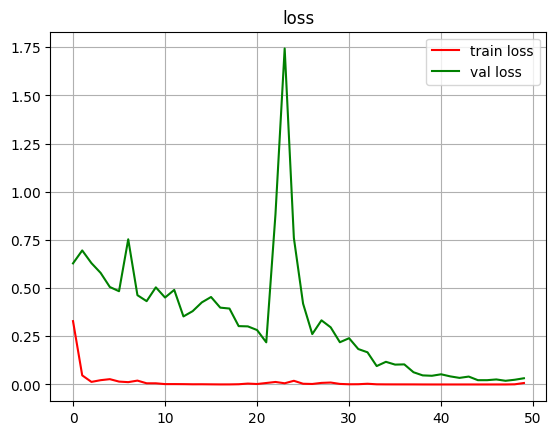

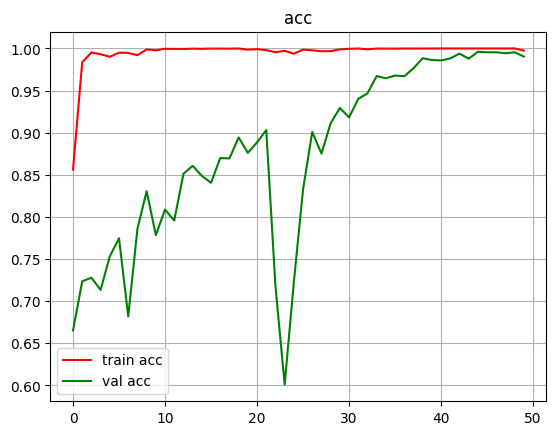

train loss:  0.00015810834826736122
val loss:  0.019234912935644388
train acc:  1.0
val acc:  0.9942915737628937


In [ ]:
train_loss_ft, val_loss_ft, train_acc_ft, val_acc_ft = fit(mobile_fine_tuning_model, bone_fracture_train_loader, bone_fracture_val_loader, epochs=50,patience=10)

## Modelo 5: MobileNetV3 Small - Feature Extractor

In [ ]:
mobile_feature_extractor_model = MobileNetV3(n_classes=1)
mobile_feature_extractor_model.freeze()
mobile_feature_extractor_model.to('cuda')
torchsummary.summary(mobile_feature_extractor_model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 90, 90]             432
       BatchNorm2d-2           [-1, 16, 90, 90]              32
         Hardswish-3           [-1, 16, 90, 90]               0
            Conv2d-4           [-1, 16, 45, 45]             144
       BatchNorm2d-5           [-1, 16, 45, 45]              32
              ReLU-6           [-1, 16, 45, 45]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 45, 45]               0
           Conv2d-13           [-1, 16, 45, 45]             256
      BatchNorm2d-14           [-1, 16,

val_loss 0.66612 val_acc 0.55277: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Epoch 1/50 loss 0.65602 val_loss 0.66612 acc 0.62516 val_acc 0.55277


val_loss 0.62764 val_acc 0.66281: 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Epoch 2/50 loss 0.59372 val_loss 0.62764 acc 0.73092 val_acc 0.66281


val_loss 0.63026 val_acc 0.65365: 100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


Epoch 3/50 loss 0.54649 val_loss 0.63026 acc 0.77183 val_acc 0.65365


val_loss 0.63708 val_acc 0.63607: 100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Epoch 4/50 loss 0.51811 val_loss 0.63708 acc 0.78984 val_acc 0.63607


val_loss 0.63172 val_acc 0.62953: 100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Epoch 5/50 loss 0.49222 val_loss 0.63172 acc 0.79950 val_acc 0.62953


val_loss 0.60348 val_acc 0.65139: 100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Epoch 6/50 loss 0.46982 val_loss 0.60348 acc 0.81214 val_acc 0.65139


val_loss 0.56385 val_acc 0.72110: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Epoch 7/50 loss 0.45582 val_loss 0.56385 acc 0.82077 val_acc 0.72110


val_loss 0.52681 val_acc 0.76279: 100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Epoch 8/50 loss 0.43775 val_loss 0.52681 acc 0.82758 val_acc 0.76279


val_loss 0.50751 val_acc 0.78224: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Epoch 9/50 loss 0.42090 val_loss 0.50751 acc 0.83745 val_acc 0.78224


val_loss 0.50484 val_acc 0.79291: 100%|██████████| 2/2 [00:09<00:00,  4.93s/it]


Epoch 10/50 loss 0.41937 val_loss 0.50484 acc 0.83176 val_acc 0.79291


val_loss 0.47022 val_acc 0.81086: 100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


Epoch 11/50 loss 0.40250 val_loss 0.47022 acc 0.85113 val_acc 0.81086


val_loss 0.47573 val_acc 0.79606: 100%|██████████| 2/2 [00:10<00:00,  5.00s/it]


Epoch 12/50 loss 0.39167 val_loss 0.47573 acc 0.84803 val_acc 0.79606


val_loss 0.46497 val_acc 0.81574: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Epoch 13/50 loss 0.38890 val_loss 0.46497 acc 0.85565 val_acc 0.81574


val_loss 0.45489 val_acc 0.81905: 100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Epoch 14/50 loss 0.38127 val_loss 0.45489 acc 0.85523 val_acc 0.81905


val_loss 0.45033 val_acc 0.81597: 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


Epoch 15/50 loss 0.36729 val_loss 0.45033 acc 0.86728 val_acc 0.81597


val_loss 0.44790 val_acc 0.82070: 100%|██████████| 2/2 [00:10<00:00,  5.08s/it]


Epoch 16/50 loss 0.36260 val_loss 0.44790 acc 0.86326 val_acc 0.82070


val_loss 0.43941 val_acc 0.81619: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Epoch 17/50 loss 0.35606 val_loss 0.43941 acc 0.86780 val_acc 0.81619


val_loss 0.45915 val_acc 0.80628: 100%|██████████| 2/2 [00:10<00:00,  5.08s/it]


Epoch 18/50 loss 0.35180 val_loss 0.45915 acc 0.86894 val_acc 0.80628


val_loss 0.42966 val_acc 0.80966: 100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Epoch 19/50 loss 0.35215 val_loss 0.42966 acc 0.86469 val_acc 0.80966


val_loss 0.44713 val_acc 0.81755: 100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


Epoch 20/50 loss 0.35089 val_loss 0.44713 acc 0.86251 val_acc 0.81755


val_loss 0.45597 val_acc 0.81477: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Epoch 21/50 loss 0.34285 val_loss 0.45597 acc 0.86911 val_acc 0.81477


val_loss 0.45847 val_acc 0.80463: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


Epoch 22/50 loss 0.33589 val_loss 0.45847 acc 0.87271 val_acc 0.80463


val_loss 0.45300 val_acc 0.81980: 100%|██████████| 2/2 [00:10<00:00,  5.05s/it]


Epoch 23/50 loss 0.33391 val_loss 0.45300 acc 0.87323 val_acc 0.81980


val_loss 0.46290 val_acc 0.79562: 100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Epoch 24/50 loss 0.32533 val_loss 0.46290 acc 0.87836 val_acc 0.79562


val_loss 0.46570 val_acc 0.79126: 100%|██████████| 2/2 [00:10<00:00,  5.44s/it]


Epoch 25/50 loss 0.32845 val_loss 0.46570 acc 0.87424 val_acc 0.79126


val_loss 0.46180 val_acc 0.79967: 100%|██████████| 2/2 [00:10<00:00,  5.07s/it]


Epoch 26/50 loss 0.32433 val_loss 0.46180 acc 0.88126 val_acc 0.79967


val_loss 0.47885 val_acc 0.77811: 100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


Epoch 27/50 loss 0.31618 val_loss 0.47885 acc 0.88310 val_acc 0.77811


val_loss 0.46954 val_acc 0.78998: 100%|██████████| 2/2 [00:09<00:00,  4.83s/it]


Epoch 28/50 loss 0.30568 val_loss 0.46954 acc 0.88847 val_acc 0.78998


val_loss 0.47137 val_acc 0.79794: 100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Epoch 29/50 loss 0.31191 val_loss 0.47137 acc 0.88030 val_acc 0.79794
Early stopping after 30 epochs
Best model weights restored.


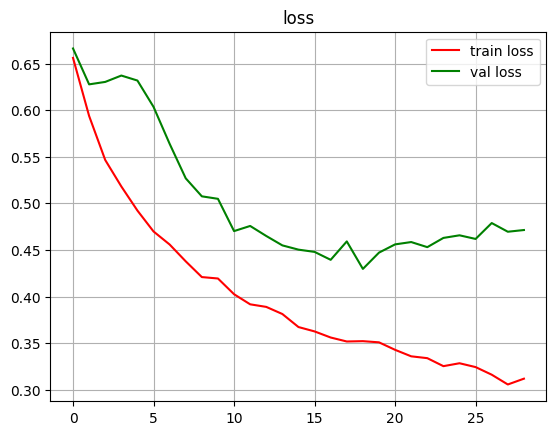

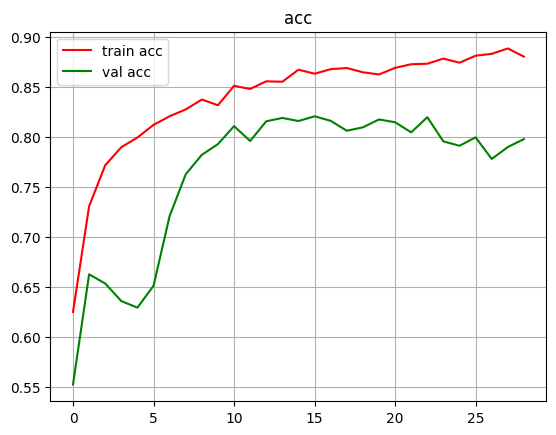

train loss:  0.3521526361766614
val loss:  0.4296645075082779
train acc:  0.864686131477356
val acc:  0.8096596598625183


In [ ]:
train_loss_ft, val_loss_ft, train_acc_ft, val_acc_ft = fit(mobile_feature_extractor_model, bone_fracture_train_loader, bone_fracture_val_loader, epochs=50,patience=10)

# Resultados

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_curve, auc

def show_confusion_matrix(y_test, y_pred,name):
    cm_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_matrix)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(name)
    ax.grid(False)
    disp.plot(ax=ax)

def plot_roc_curve(y_test, y_pred, name):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC: ' + name)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def results(model,name):
  model.eval()
  with torch.no_grad():
      for batch in bone_fracture_test_loader:
          X, y = batch
          X, y = X.to(device), y.to(device)
          y_hat = model(X)
          y_hat = torch.sigmoid(y_hat.squeeze())
          y_hat, y  = np.round(y_hat.cpu().detach().numpy()).astype(int),np.round(y.cpu().detach().numpy()).astype(int)
          print('El acc es :' , accuracy_score(y_hat,y))
          print('El f1-score es :', f1_score(y_hat,y))
          show_confusion_matrix(y, y_hat,name)
          plot_roc_curve(y, y_hat,name)


Modelo convolucional
El acc es : 0.9723320158102767
El f1-score es : 0.9732824427480916


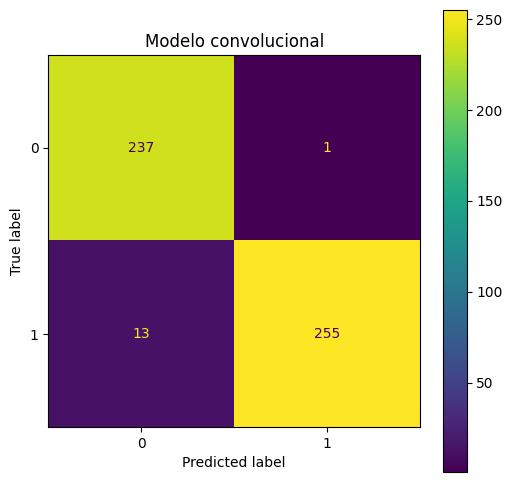

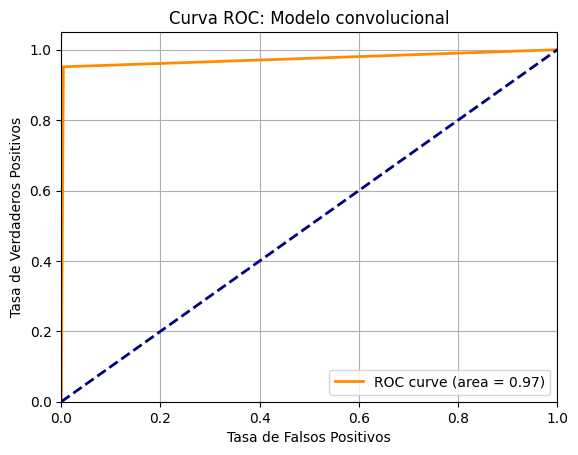

In [ ]:
print('Modelo convolucional')
results(conv_model,'Modelo convolucional')

Resnet18 fine tuning
El acc es : 0.9901185770750988
El f1-score es : 0.9905838041431261


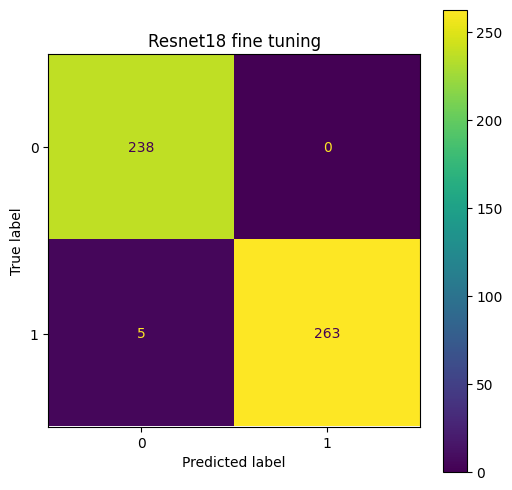

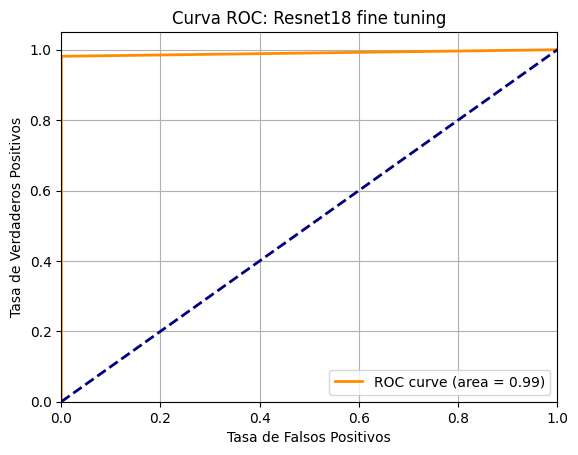

In [ ]:
print('Resnet18 fine tuning')
results(resnet_fine_tuning_model,'Resnet18 fine tuning')

Resnet18 feature extractor
El acc es : 0.7944664031620553
El f1-score es : 0.8066914498141264


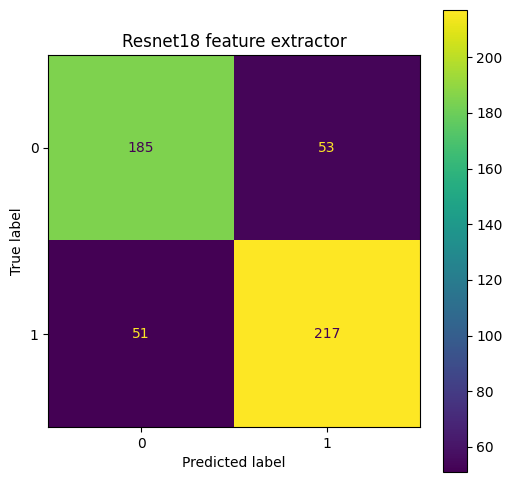

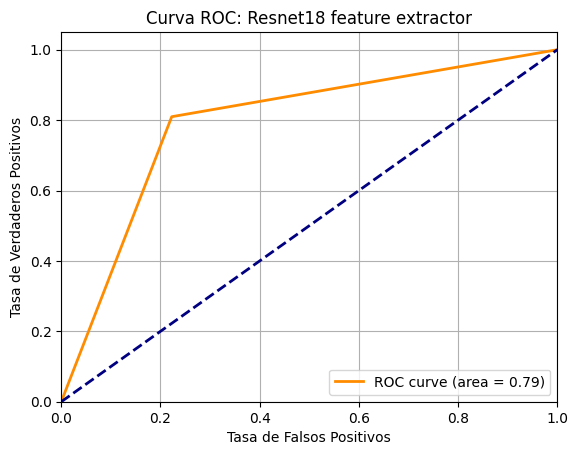

In [ ]:
print('Resnet18 feature extractor')
results(resnet_feature_extractor_model,'Resnet18 feature extractor')

MobileNet fine tuning
El acc es : 0.974308300395257
El f1-score es : 0.9761467889908257


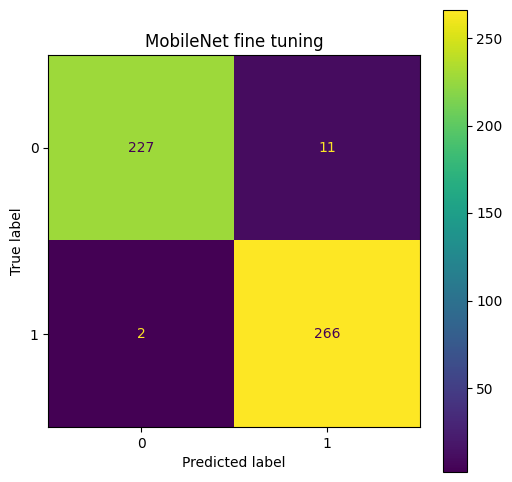

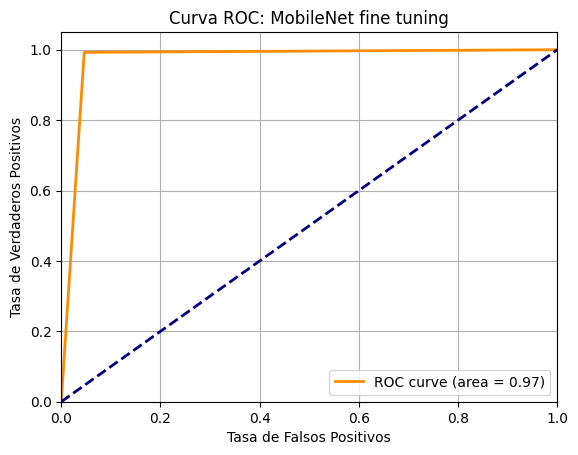

In [ ]:
print('MobileNet fine tuning')
results(mobile_fine_tuning_model,'MobileNet fine tuning')

MobileNet feature extractor
El acc es : 0.7193675889328063
El f1-score es : 0.6939655172413793


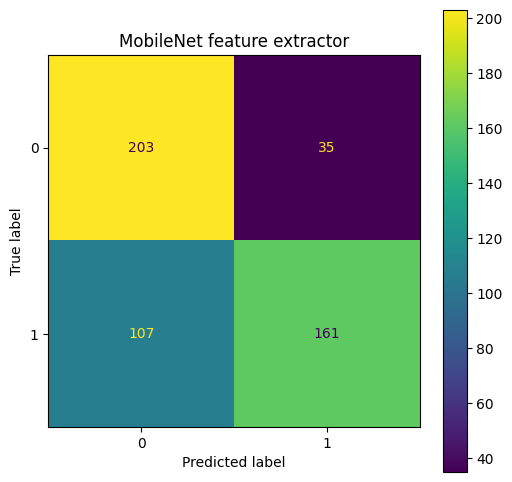

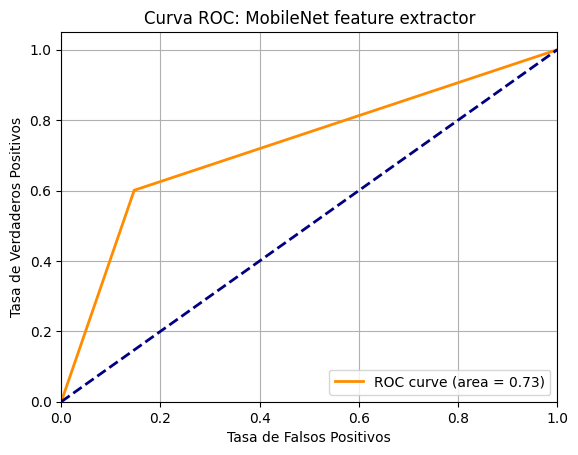

In [ ]:
print('MobileNet feature extractor')
results(mobile_feature_extractor_model,'MobileNet feature extractor')

In [ ]:
torch.save(conv_model.state_dict(), 'conv_model.pth')
torch.save(resnet_fine_tuning_model.state_dict(), 'resnet_fine_tuning_model.pth')
torch.save(resnet_feature_extractor_model.state_dict(), 'resnet_feature_extractor_model.pth')
torch.save(mobile_fine_tuning_model.state_dict(), 'mobile_fine_tuning_model.pth')
torch.save(mobile_feature_extractor_model.state_dict(), 'mobile_feature_extractor_model.pth')

## Conclusión

- Podemos aplicar diferentes modelos de visión por computadora a un problema real.

- Pudimos tomar decisiones considerando el dominio del problema.

- Logramos una precisión buena.
